In [106]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed, Reshape
import tensorflow as tf

In [107]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel('ADAUSDT.xlsx')
#df = pd.read_excel('BNBUSDT.xlsx')
#df = pd.read_excel('ETHUSDT.xlsx')
df1=df.reset_index()['Close']

In [108]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [109]:
# # 4. Chia train val test 7 - 1 - 2
# train_size = int(0.7 * len(df1))
# val_size = int(0.1 * len(df1))
# test_size = len(df1) - train_size - val_size

# train_data = df1[:train_size]
# val_data = df1[train_size:train_size+val_size]
# test_data = df1[train_size+val_size:]

In [110]:
# 4. Chia train val test 6 - 2 - 2
train_size = int(0.6 * len(df1))
val_size = int(0.2 * len(df1))
test_size = len(df1) - train_size - val_size

train_data = df1[:train_size]
val_data = df1[train_size:train_size+val_size]
test_data = df1[train_size+val_size:]

In [111]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [112]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [113]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [114]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [115]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_val,yval),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 56ms/step - loss: 0.0598 - val_loss: 0.0038
Epoch 2/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0230 - val_loss: 0.0075
Epoch 3/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0166 - val_loss: 0.0053
Epoch 4/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0141 - val_loss: 0.0029
Epoch 5/100
13/13 [==============================] - 1s 48ms/step - loss: 0.0116 - val_loss: 0.0016
Epoch 6/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0094 - val_loss: 0.0018
Epoch 7/100
13/13 [==============================] - 1s 49ms/step - loss: 0.0083 - val_loss: 0.0012
Epoch 8/100
13/13 [==============================] - 1s 46ms/step - loss: 0.0074 - val_loss: 5.7284e-04
Epoch 9/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0070 - val_loss: 4.5446e-04
Epoch 10/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0059 - val_loss

In [116]:
# 10. Dự báo dữ liệu test, val
train_predict = (model.predict(X_train) > 0.5).astype("int32")
y_pred_val = (model.predict(X_val) > 0.5).astype("int32")
y_pred = (model.predict(X_test) > 0.5).astype("int32")

7/7 [==============================] - 0s 10ms/step


In [117]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred_val = scaler.inverse_transform(y_pred_val)
y_pred = scaler.inverse_transform(y_pred)

In [118]:
# 12. Đánh giá độ chính xác thuật toán bằng MAE và RMSE
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(y_pred_val, yval)
test_mae = mean_absolute_error(y_pred, ytest)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation MAE: 0.012712244539039056
Testing MAE: 0.008226349211227727
Validation RMSE: 0.01399809623184543
Testing RMSE: 0.009988893223864759


In [119]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array
import numpy as np

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) >= 100:
        x_input = np.array(temp_input[:100])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        padding = np.zeros((100 - len(temp_input),))
        x_input = np.concatenate((np.array(temp_input), padding), axis=0)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


0 day output [[0.03419467]]
1 day output [[0.03419892]]
2 day output [[0.03415639]]
3 day output [[0.03429211]]
4 day output [[0.03428403]]
5 day output [[0.03438531]]
6 day output [[0.03434079]]
7 day output [[0.03439479]]
8 day output [[0.03437681]]
9 day output [[0.03439631]]
10 day output [[0.03439635]]
11 day output [[0.03440365]]
12 day output [[0.03441083]]
13 day output [[0.03443247]]
14 day output [[0.03438383]]
15 day output [[0.03433935]]
16 day output [[0.03425692]]
17 day output [[0.03414404]]
18 day output [[0.0342007]]
19 day output [[0.03424732]]
20 day output [[0.03426044]]
21 day output [[0.03427698]]
22 day output [[0.03421774]]
23 day output [[0.03412873]]
24 day output [[0.03409567]]
25 day output [[0.03416001]]
26 day output [[0.03430399]]
27 day output [[0.03455994]]
28 day output [[0.03449244]]
29 day output [[0.03473265]]


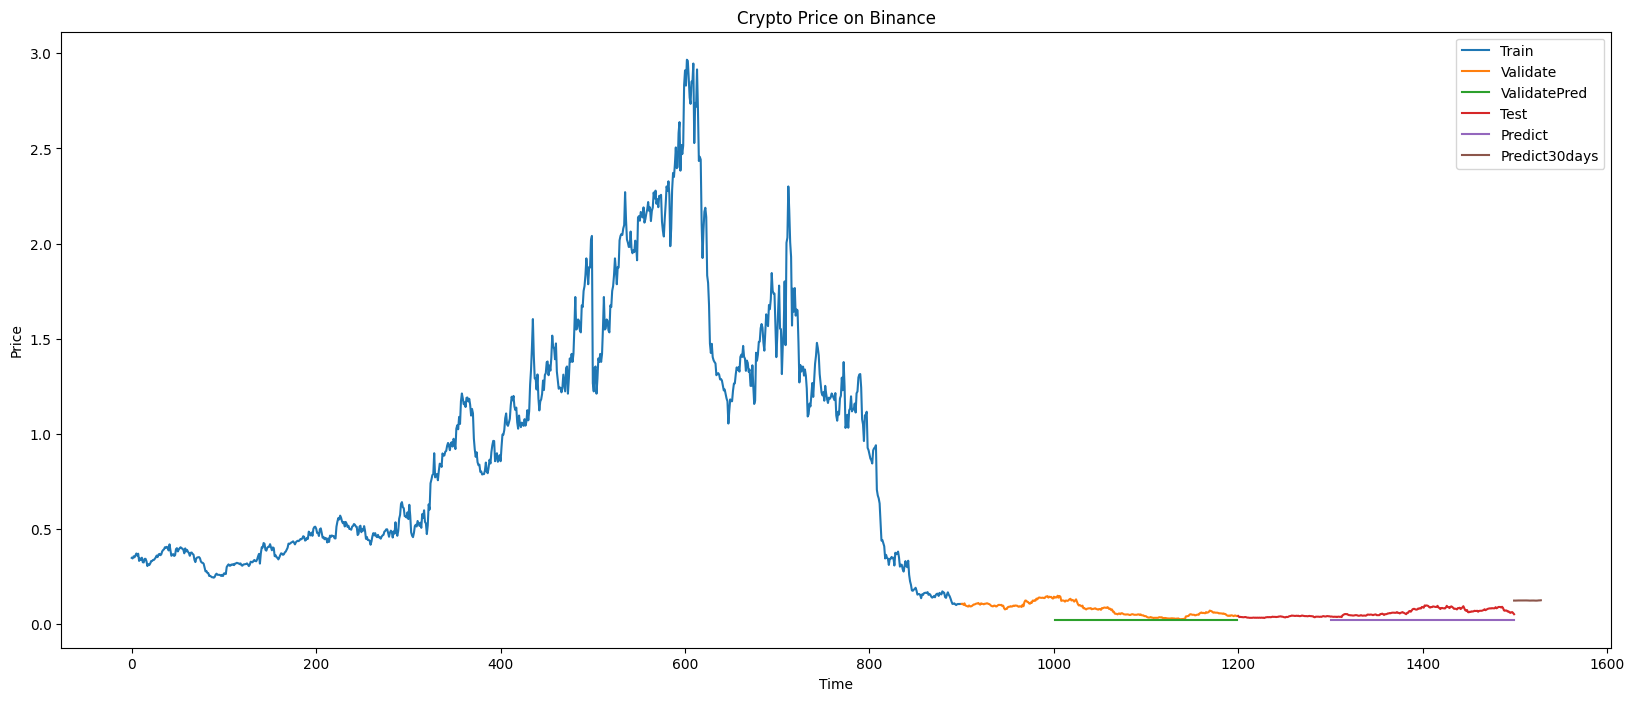

In [120]:
# 14.Vẽ hình
plt.figure(figsize=(20, 8))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

val_data_index = pd.RangeIndex(start=train_size, stop=train_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

test_data_index = pd.RangeIndex(start=train_size+val_size, stop=train_size+val_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+val_size+101, stop=train_size+val_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Crypto Price on Binance')
plt.legend(['Train','Validate','ValidatePred', 'Test','Predict', 'Predict30days'])
plt.show()